In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

# DFT analysis of the bulk WSe$_2$

## GS analysis

We use the input file 'Pw_input_Marini/scf.in' as starting point for the DFT analysis

In [4]:
inp = I.PwInput(file='Pw_input_Marini/scf.in')
inp.set_pseudo_dir('../pseudos')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'WSe2'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.TRUE.',
  'ibrav': 4,
  'celldm(1)': 6.1983017192617,
  'celldm(3)': 3.95,
  'ntyp': 2,
  'nat': 6,
  'ecutwfc': 50,
  'noncolin': '.true.',
  'lspinorb': '.true.'},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': '1.0d-6'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Se': [32.065, 'Se_FR.upf'], 'W': [183.84, 'W_FR.upf']},
 'atomic_positions': {'type': 'crystal',
  'values': [['W', [0.333333, 0.666667, 0.25]],
   ['W', [0.666667, 0.333333, 0.75]],
   ['Se', [0.333333, 0.666667, 0.621148493]],
   ['Se', [0.666667, 0.333333, 0.121148493]],
   ['Se', [0.333333, 0.666667, 0.878851507]],
   ['Se', [0.666667, 0.333333, 0.378851507]]]},
 'kpoints': {'type': 'automatic',
  'values': ([9.0, 9.0, 1.0], [1.0, 1.0, 0.0])},
 'cell_parameters': {},
 'file': 'Pw_input_Marini/scf.in'}

We plot the lattice positions of the atoms

In [18]:
alat = inp['system']['celldm(1)'] # in a.u. (Bohr)
celldm3 = inp['system']['celldm(3)'] # in units of alat
atoms = inp['atomic_positions']['values']

lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
positions = LL.build_lattice(lattice,atoms,6,6,3)

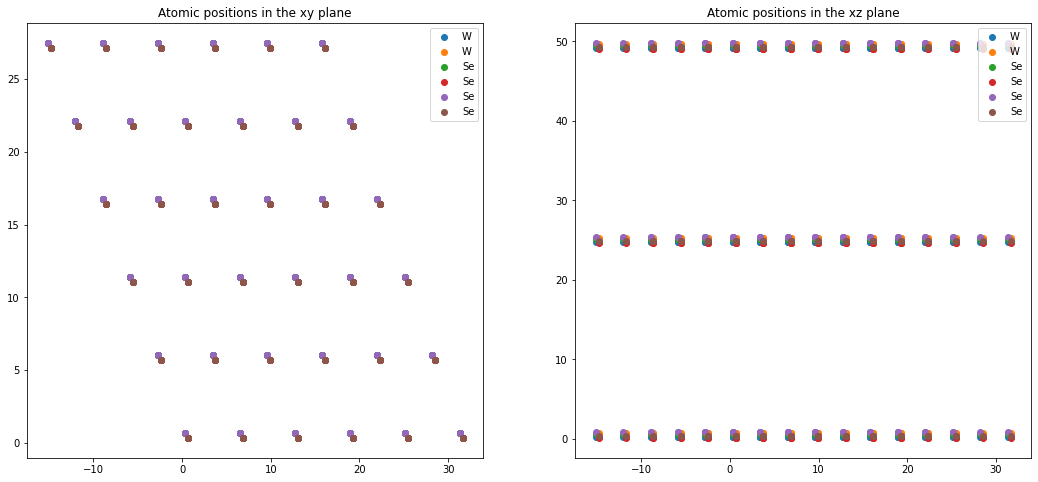

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 8))

for pos in positions:
    ax[0].scatter(pos[1],pos[2],label=pos[0])
ax[0].set_title('Atomic positions in the xy plane',size=12)
ax[0].legend()

for pos in positions:
    ax[1].scatter(pos[1],pos[3],label=pos[0])
ax[1].set_title('Atomic positions in the xz plane',size=12)
ax[1].legend()

We perform scf calculations for various $k$-points sampling.

We perform a convergence procedure of the scf $k$-points sampling using the total energy
and the band gap value as control quantities

In [8]:
run_dir = 'DFT_analysis'

In [9]:
kvalues = [[12,12,3],[15,15,3],[18,18,4]]

In [10]:
study = D.Dataset(run_dir=run_dir,num_tasks=3)

for k in kvalues:
    idd = 'scf-kpoints_%sx%sx%s'%(k[0],k[1],k[2])
    inp.set_prefix(D.name_from_id(idd))
    inp.set_num_bnds(54)
    inp.set_kpoints(type='automatic',points=k)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 3 parallel tasks


In [11]:
#study.runs[0]

In [12]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run ofSkip the run of  scf-kpoints_15x15x3
scf-kpoints_18x18x4
Skip the run of scf-kpoints_12x12x3
Task [0, 1, 2] ended 
 


In [13]:
for r in results.values():
    print(r.energy)

-189.9260048713656
-189.9260024311404
-189.9260035968925


In [14]:
for r in results.values():
    print(r.get_gap())

Indirect gap system
Gap : 0.910425261703681 eV
Direct gap : 1.3347820285864245 eV
{'gap': 0.910425261703681, 'direct_gap': 1.3347820285864245, 'position_cbm': 40, 'positon_vbm': 0, 'positon_direct_gap': 52}
Indirect gap system
Gap : 0.9037334787581894 eV
Direct gap : 1.3346669675759024 eV
{'gap': 0.9037334787581894, 'direct_gap': 1.3346669675759024, 'position_cbm': 75, 'positon_vbm': 0, 'positon_direct_gap': 108}
Indirect gap system
Gap : 0.9035789906358005 eV
Direct gap : 1.3349688553619057 eV
{'gap': 0.9035789906358005, 'direct_gap': 1.3349688553619057, 'position_cbm': 24, 'positon_vbm': 0, 'positon_direct_gap': 36}


We use the 12x12x3 k samplings as the converged value for the scf calculations in what follows

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [61]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [63]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.5773502691896258, 0.0, 30],
 [0.3333333333333333, 0.5773502691896258, 0.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [65]:
inp.set_bands(60,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 4,
  'celldm(1)': 6.1983017192617,
  'celldm(3)': 3.95,
  'ntyp': 2,
  'nat': 6,
  'ecutwfc': 50,
  'noncolin': '.true.',
  'lspinorb': '.true.',
  'nbnd': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Se': [32.065, 'Se_FR.upf'], 'W': [183.84, 'W_FR.upf']},
 'atomic_positions': {'type': 'crystal',
  'values': [['W', [0.333333, 0.666667, 0.25]],
   ['W', [0.666667, 0.333333, 0.75]],
   ['Se', [0.333333, 0.666667, 0.621148493]],
   ['Se', [0.666667, 0.333333, 0.121148493]],
   ['Se', [0.333333, 0.666667, 0.878851507]],
   ['Se', [0.666667, 0.333333, 0.378851507]]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.5773502691896258, 0.0, 30],
   [0.3333333333333333, 0.5773502691896258, 0.0, 30],
   [0.0

In [66]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/scf-kpoints_12x12x3.save')

copy source_dir DFT_analysis/scf-kpoints_12x12x3.save in the /work/dalessandro/NEQ_EXCITONIC_TRANSITIONS/WSe2/DFT_analysis/bands.save
run command: mpirun -np 16 pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [67]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [68]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

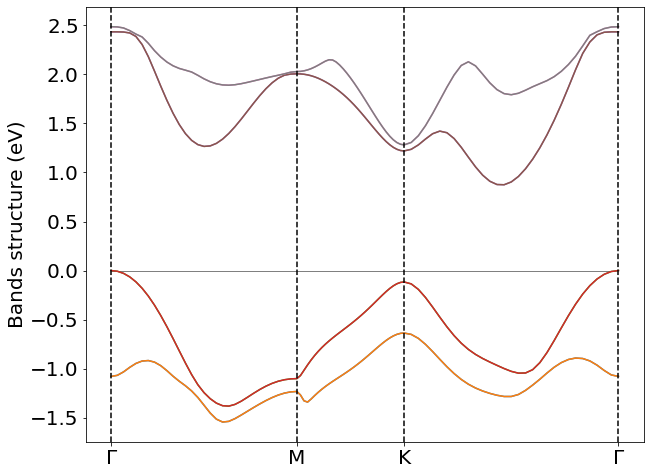

In [72]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(48,56)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## NSCF computations on regular grids

We compute the KS states on the various $k$-samplings.

We also compare the results due to shifted grids

In [13]:
kvalues = [[12,12,3],[15,15,4],[18,18,5],[24,24,6]]

In [14]:
nbnds = 100 #60
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
#inp

In [15]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':'%sx%sx%s'%(k[0],k[1],k[2]),'nbnds':nbnds}
    #idd = {'kpoints':'%sx%sx%s_shifted'%(k[0],k[1],k[2]),'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=k)
    #inp.set_kpoints(points=k,shift=[1.,1.,0.])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/scf-kpoints_12x12x3.save')

Initialize a Dataset with 1 parallel tasks


In [16]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_12x12x3-nbnds_100'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'ibrav': 4,
   'celldm(1)': 6.1983017192617,
   'celldm(3)': 3.95,
   'ntyp': 2,
   'nat': 6,
   'ecutwfc': 50,
   'noncolin': '.true.',
   'lspinorb': '.true.',
   'nbnd': 100},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Se': [32.065, 'Se_FR.upf'], 'W': [183.84, 'W_FR.upf']},
  'atomic_positions': {'type': 'crystal',
   'values': [['W', [0.333333, 0.666667, 0.25]],
    ['W', [0.666667, 0.333333, 0.75]],
    ['Se', [0.333333, 0.666667, 0.621148493]],
    ['Se', [0.666667, 0.333333, 0.121148493]],
    ['Se', [0.333333, 0.666667, 0.878851507]],
    ['Se', [0.666667, 0.333333, 0.378851507]]]},
  'kpoints': {'type': 'auto

In [10]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0], [1], [2], [3]] 

Run the task [0] 
Skip the run of kpoints_12x12x3-nbnds_100
The folder /work/dalessandro/NEQ_EXCITONIC_TRANSITIONS/WSe2/DFT_analysis/kpoints_12x12x3-nbnds_100.save already exists. Source_dir DFT_analysis/scf-kpoints_12x12x3.save not copied
Task [0] ended 
 
Run the task [1] 
Skip the run of kpoints_15x15x4-nbnds_100
The folder /work/dalessandro/NEQ_EXCITONIC_TRANSITIONS/WSe2/DFT_analysis/kpoints_15x15x4-nbnds_100.save already exists. Source_dir DFT_analysis/scf-kpoints_12x12x3.save not copied
Task [1] ended 
 
Run the task [2] 
Skip the run of kpoints_18x18x5-nbnds_100
The folder /work/dalessandro/NEQ_EXCITONIC_TRANSITIONS/WSe2/DFT_analysis/kpoints_18x18x5-nbnds_100.save already exists. Source_dir DFT_analysis/scf-kpoints_12x12x3.save not copied
Task [2] ended 
 
Run the task [3] 
Skip the run of kpoints_24x24x6-nbnds_100
The folder /work/dalessandro/NEQ_EXCITONIC_TRANSITIONS/WSe2/DFT_analysis/kpoints_2

In [11]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [12]:
kp = results[0].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 50


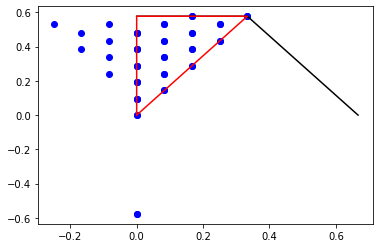

In [13]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')